## Semgrep Take-Home Project
### William Daugherty

Hello! In this Jupyter notebook, I'd like to walk you through my ideas and thought processes for how to tackle this project. The goal is to get a LLM to write Semgrep rule data for rules in YAML files.

I went through much trial and error, and I believe my ideas might help us get in the right direction.

First of all, I decided to use Cohere, which is an LLM similar to OpenAI's GPT-4. You can find the documentation for Cohere, here:

https://docs.cohere.ai/docs

In [1]:
# Imports
import cohere

In [2]:
co = cohere.Client('NNpNN3Cch0yryVyeqB3VBgxcK1sxApMxsFk9c6L3')

Here, I've written a zero-shot learning prompt for Cohere's generative model:

In [52]:
# Creating prompt

prompt = """
This program completes a set of rules in YAML format with the appropriate metadata.

Prompt:
rules:
- id: ruby-jwt-exposed-credentials
  languages: [ruby]
  message: >-
    Password is exposed through JWT token payload. This is not encrypted and
    the password could be compromised. Do not store passwords in JWT tokens.
  patterns:
  - pattern-inside: |
      require 'jwt'
      ...
  - pattern: |
      $PAYLOAD = {...,password:...,...}
      ...
      JWT.encode($PAYLOAD,...)
  severity: ERROR

  Completion:

"""

Below, I've run tests on several models. First, I used Cohere's pretrained model, `xlarge`, to try and get a prediction on the metadata:

In [62]:
# Define model settings

response = co.generate(
    model='xlarge',
    prompt=prompt,
    max_tokens=100,
    temperature=0
)

In [63]:
metadata = response.generations[0].text

In [64]:
print(metadata)

ruby-jwt-exposed-credentials:
  - id: ruby-jwt-exposed-credentials
    languages: [ruby]
    message: >-
    Password is exposed through JWT token payload. This is not encrypted and
    the password could be compromised. Do not store passwords in JWT tokens.
    patterns:
    - pattern-inside


Since this is not exactly what we're looking for, I created three different custom models, trained on datasets which I generated from a selection of YAML files found in the Semgrep repo. The Python code I used to create this dataset is found in the `prompt_engineering.ipynb` file, and the training data is contained in the `testing_data.txt` file, both located in the folder called `testing_files` in my forked repo.

I've also included Cohere's **Accuracy** and **Loss** metrics for each model I created.

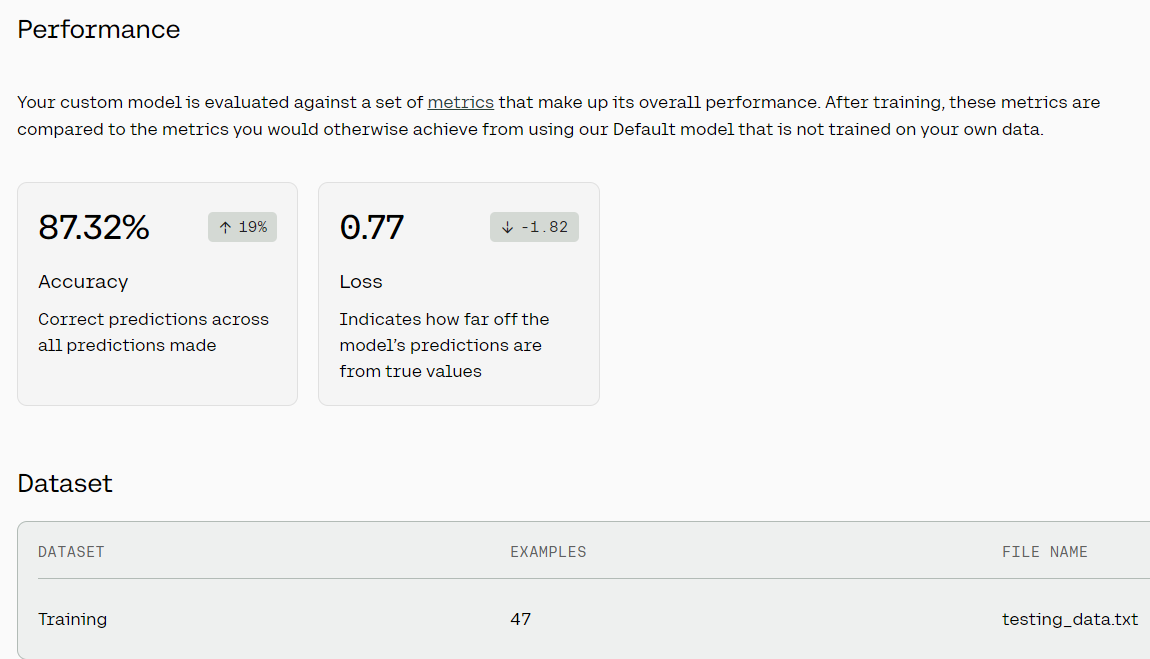

In [53]:
# Testing the custom yaml_metadata-1348 model

import cohere
co = cohere.Client('NNpNN3Cch0yryVyeqB3VBgxcK1sxApMxsFk9c6L3') # This is your trial API key
response = co.generate(
  model='2cc2f7bc-8acc-4072-9026-5830162e6483-ft',
  prompt=prompt)
print('Prediction: \n\n{}'.format(response.generations[0].text))

Prediction: 

rules:
- id: audit-file-on-disk
  languages: [yaml


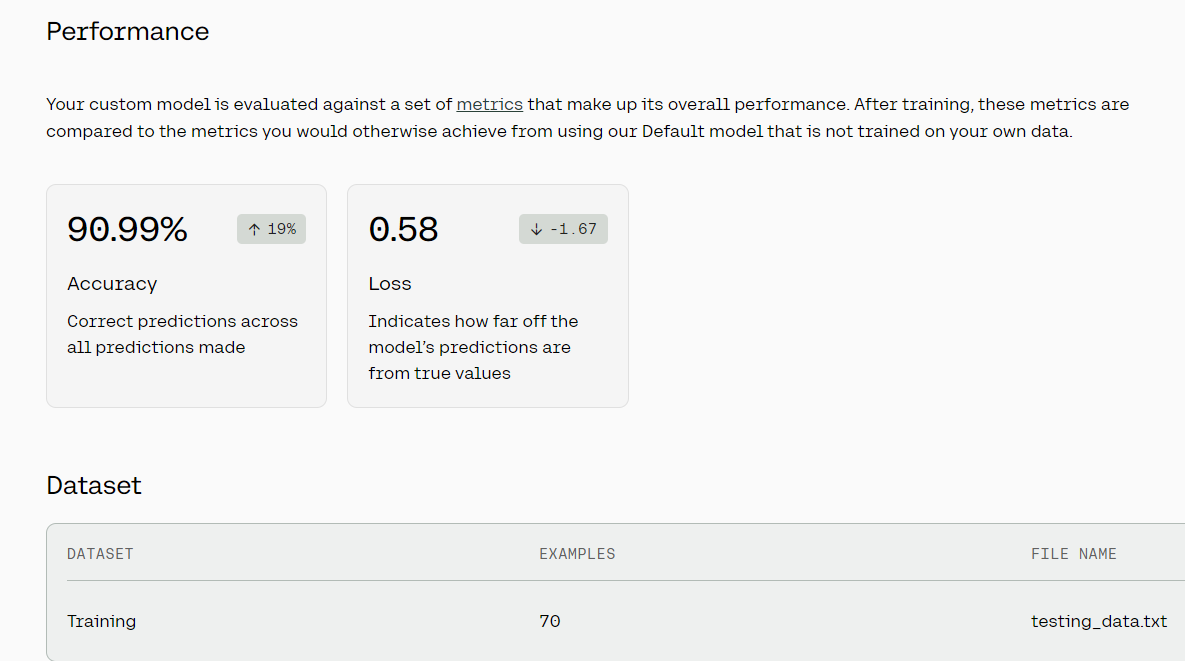

In [54]:
# Second round of testing

import cohere
co = cohere.Client('NNpNN3Cch0yryVyeqB3VBgxcK1sxApMxsFk9c6L3') # This is your trial API key
response = co.generate(
  model='3685a84f-a5bf-4672-97a2-0fedb2e4eab2-ft',
  prompt=prompt,
  temperature=0)
print('Prediction: {}'.format(response.generations[0].text))

Prediction:   - yaml: ruby-jwt-exposed-credentials.yam


In [55]:
print(response)

[cohere.Generation {
	text:   - yaml: ruby-jwt-exposed-credentials.yam
	likelihood: None
	token_likelihoods: None
}]


For this one, I decided to do something crazy and increase the `temperature` to 5, just to see what happened. The results are kinda funny.

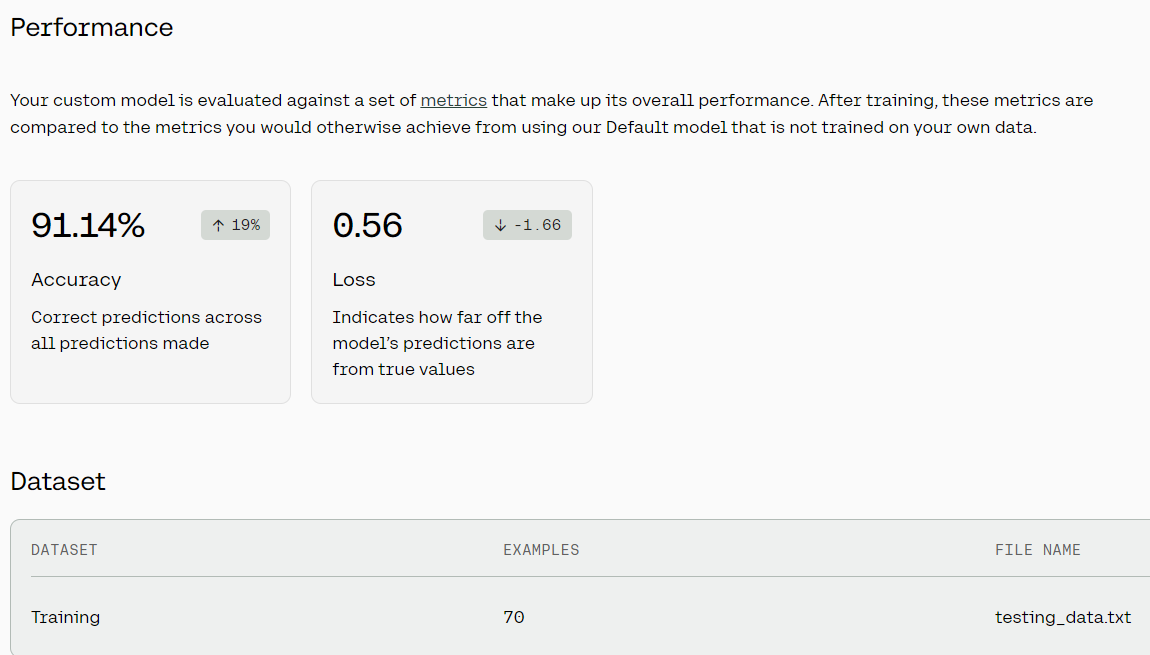

In [61]:
# Third round of testing

response_3 = co.generate(
  model='ae95fea5-c157-475a-8184-d1014b3a6965-ft',
  prompt=prompt,
  max_tokens=100,
  temperature=5)
print('Prediction: {}'.format(response_3.generations[0].text))

Prediction: This will warn you if the secret stored in the token payload is the same as the password stored in the secret. It's better to encrypt the secret than use a fixed one, which makes it possible to brute force the encryption.

Now that we've gone over how to do it, let's put this knowledge into practice with some simple examples.

### Tip

As with everything related to crypto, there is more than one way to solve the problem. One way to do


As you can see, with each successive model, the accuracy increases and the loss decreases. Still, we're not getting the expected result with the metadata inserted.

One suggestion I might have is that we need to train the model with the different categories of metadata and different use cases for each category. This might produce a better result.